In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [22]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [25]:
df2= pd.read_sql('select * from measurement', conn)

In [26]:
df2.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [27]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables


In [28]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station


In [30]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set.
recent_date_string = session.query(func.max(measurement.date)).scalar()
recent_date = dt.datetime.strptime(recent_date_string, '%Y-%m-%d')


([<matplotlib.axis.XTick at 0x175420e9040>,
 [Text(0, 0, '2016-08-24'),
  Text(1, 0, '2016-08-24'),
  Text(2, 0, '2016-08-24'),
  Text(3, 0, '2016-08-24'),
  Text(4, 0, '2016-08-24'),
  Text(5, 0, '2016-08-24'),
  Text(6, 0, '2016-08-24'),
  Text(7, 0, '2016-08-25'),
  Text(8, 0, '2016-08-25')])

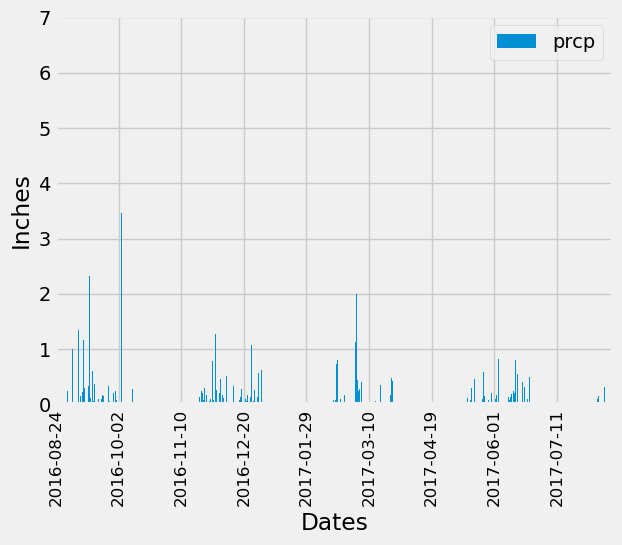

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
start_date = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_rain = session.query(measurement.date, measurement.prcp).filter(measurement.date >= start_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_rain,columns=['date','prcp'])
df.set_index('date',inplace=True)
df.sort_values(by='date',inplace=True,ascending=True)
# Sort the dataframe by date
daily_precip = df.groupby(df.index)['prcp'].agg('sum')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(use_index = True, kind='bar',xlabel='Dates',ylabel='Inches')
plt.xticks(rotation=90)
#plt.figure(figsize=(12, 6))
plt.xticks(np.arange(0, len(df), 250),fontsize=12)



In [33]:
daily_precip.max()

14.280000000000001

In [34]:
df['prcp'].max()

6.7

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = df['prcp'].describe()
summary_stats


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [46]:
# Design a query to calculate the total number stations in the dataset
station_count =session.query(measurement.station).distinct().count()
station_count


9

In [52]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
for station in station_activity:
    print(f"Station: {station[0]}, Count: {station[1]}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [56]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_data = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281')

In [59]:

print(f'min temp:{most_active_data[0][0]}, max temp:{most_active_data[0][1]}, average temp:{most_active_data[0][2]}')

min temp:54.0, max temp:85.0, average temp:71.66378066378067


In [61]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = session.query(func.max(measurement.date)).filter(measurement.station == 'USC00519281').scalar()
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
one_year_ago = latest_date - dt.timedelta(days=365)

In [63]:
tobs_data = session.query(measurement.date, measurement.tobs) \
                   .filter(measurement.station == 'USC00519281') \
                   .filter(measurement.date >= one_year_ago) \
                   .all()

# create a DataFrame from the TOBS data
tobs_df = pd.DataFrame(tobs_data, columns=['date', 'tobs'])

Text(0.5, 1.0, 'Temperature Observations for Station USC00519281\n2016-08-18 to 2017-08-18 00:00:00')

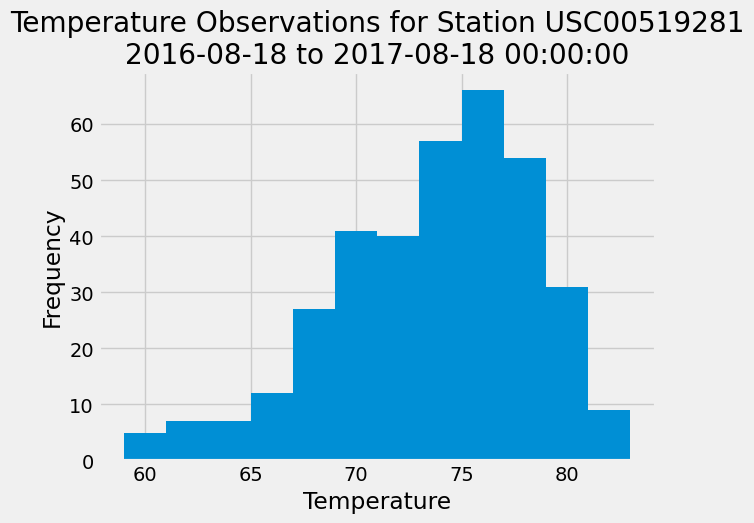

In [67]:
plt.hist(tobs_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station USC00519281\n{one_year_ago.date()} to {latest_date}')

# Close session

In [40]:
# Close Session
session.close()